In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew, norm
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6) #set default figure size
rng = np.random.default_rng() # random generator

## 4.1

In [2]:
S0 = 50 # initial stock price
r = 0.05 # risk-free rate
q = 0.02 # dividend yield
T = 1 # maturity
sigma1 = 0.2 # volatility 1
sigma2 = 0.5 # volatility 2
N = 500 # number of simulations

In [3]:
z = rng.standard_normal(size=N)
x = (rng.random(size=N) < 0.5).astype(int) # 0 or 1
sigma = sigma1 * x + sigma2 * (1 - x) # volatility
log_ST = np.log(S0) + (r - q - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * z

print("Mean of log(S_T): ", np.mean(log_ST))
print("Standard Deviation of log(S_T): ", np.std(log_ST))
print("Fraction that lie more than two std below the mean:", np.mean(log_ST < (np.mean(log_ST) - 2 * np.std(log_ST))))

Mean of log(S_T):  3.8676149686079544
Standard Deviation of log(S_T):  0.3751367234006503
Fraction that lie more than two std below the mean: 0.034


## 4.2

In [4]:
def simulating_GARCH(S0, sigma0, r, q, dt, N, _kappa, _lambda, _theta, M=500):
    sigma = np.zeros((M, N + 1))
    log_S = np.zeros((M, N + 1))
    y = np.zeros((M, N + 1))
    sigma[:, 0] = sigma0
    log_S[:, 0] = np.log(S0)
    y[:, 0] = rng.standard_normal(size=M) * sigma[:, 0]
    for i in range(1, N + 1):
        sigma[:, i] = np.sqrt(_kappa * _theta + (1 - _kappa) * (1 - _lambda) * y[:, i - 1] ** 2 + (1 - _kappa) * _lambda * sigma[:, i - 1] ** 2)
        y[:, i] = rng.standard_normal(size=M) * sigma[:, i]
        log_S[:, i] = log_S[:, i - 1] + (r - q - 0.5 * sigma[:, i] ** 2) * dt + y[:, i] * np.sqrt(dt)
    return log_S[:, -1]

In [29]:
log_ST = simulating_GARCH(S0=100, sigma0=0.3, r=0.05, q=0.01, dt=0.01, N=100, _kappa=0.2, _lambda=0.2, _theta=0.09)
print("Mean of log(S_T): ", np.mean(log_ST))
print("Standard Deviation of log(S_T): ", np.std(log_ST))
print("Fraction that lie more than two std below the mean:", np.mean(log_ST < (np.mean(log_ST) - 2 * np.std(log_ST))))
#print("Skewness of log(S_T): ", skew(log_ST))
#print("Kurtosis of log(S_T): ", kurtosis(log_ST))

Mean of log(S_T):  4.594909658736306
Standard Deviation of log(S_T):  0.30340120949983435
Fraction that lie more than two std below the mean: 0.032


## 4.3

In [30]:
def stochastic_volatility(S0, V0, r, q, dt, N, theta, kappa, gamma, rho, M=500):
    log_S = np.zeros((M, N + 1))
    log_S[:, 0] = np.log(S0)
    V = np.zeros((M, N + 1))
    V[:, 0] = V0
    for i in range(1, N + 1):
        Z1 = rng.standard_normal(size=M)
        Z2 = rho * Z1 + np.sqrt(1 - rho ** 2) * rng.standard_normal(size=M)
        log_S[:, i] = log_S[:, i - 1] + (r - q - 0.5 * V[:, i - 1]) * dt + np.sqrt(V[:, i - 1] * dt) * Z1
        V[:, i] = V[:, i - 1] + kappa * (theta - V[:, i - 1]) * dt + gamma * np.sqrt(V[:, i - 1] * dt) * Z2
    return  log_S[:, -1]

In [46]:
log_ST = stochastic_volatility(S0=100, V0=0.09, r=0.05, q=0.02, dt=0.01, N=100, theta=0.09, kappa=0.01, gamma=0.1, rho=0.1)
print("Mean of log(S_T): ", np.mean(log_ST))
print("Standard Deviation of log(S_T): ", np.std(log_ST))
print("Fraction that lie more than two std below the mean:", np.mean(log_ST < (np.mean(log_ST) - 2 * np.std(log_ST))))

Mean of log(S_T):  4.580027935814651
Standard Deviation of log(S_T):  0.28796754748478515
Fraction that lie more than two std below the mean: 0.022


## 5.1

In [2]:
def stock_tree(S0, sigma, T, N):
    """Stock price tree

    Args:
        S0 (float): initial stock price
        sigma (float): volatility
        T (float): time to maturity
        N (int): number of steps

    Returns:
        numpy.ndarray: stock price tree
    """
    dt = T / N # time step
    u = np.exp(sigma * np.sqrt(dt)) # up factor (Cox-Ross-Rubinstein model)
    d = 1 / u # down factor
    S = np.zeros((N + 1, N + 1))
    S[0, 0] = S0
    for t in range(1, N + 1):
        for i in range(t + 1):
            S[i, t] = S0 * u ** (t - i) * d ** i # i down, t - i up
    return S

def euro_call_tree(S0, sigma, T, N, K, r, q=0):
    """European call option price tree

    Args:
        S0 (float): initial stock price
        sigma (float): volatility
        T (float): time to maturity
        N (int): number of steps
        K (float): strike price
        r (float): risk-free rate
        q (float, optional): dividend yields. Defaults to 0.

    Returns:
        numpy.ndarray: European call option price tree
    """
    S = stock_tree(S0, sigma, T, N)
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp((r - q) * dt) - d) / (u - d) # risk-neutral probability
    euro_call = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        euro_call[i, N] = max(S[i, N] - K, 0) # payoff at maturity
    for t in range(N - 1, -1, -1):
        for i in range(t + 1):
            euro_call[i, t] = np.exp(-r * dt) * (p * euro_call[i, t + 1] + (1 - p) * euro_call[i + 1, t + 1]) # backward induction
    return euro_call

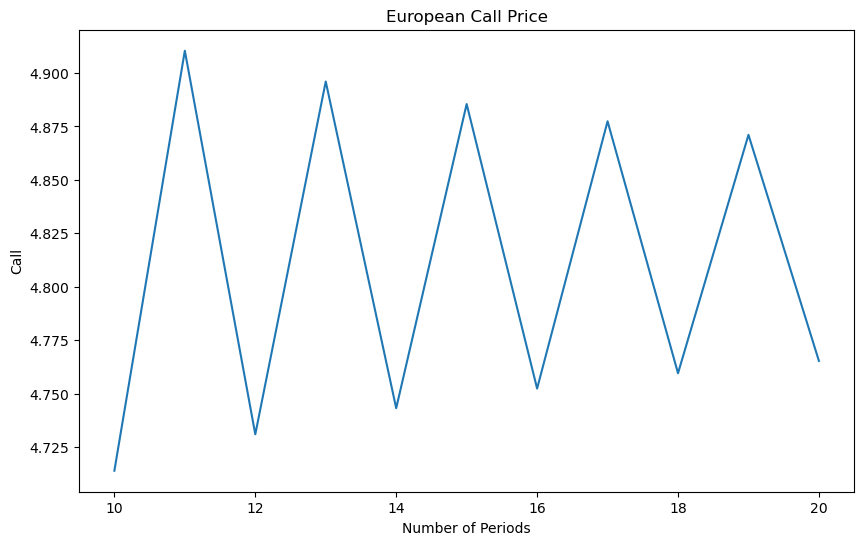

In [3]:
call_price = np.zeros(11)
for n in range(10, 21):
    call_price[n - 10] = euro_call_tree(S0=50, sigma=0.3, T=0.5, K=50, r=0.05, N=n)[0, 0]
plt.plot(range(10, 21), call_price)
plt.xlabel('Number of Periods')
plt.ylabel('Call')
plt.title('European Call Price')
plt.show()

## 5.2

In [5]:
def Black_Scholes_Call(S, K, r, T, sigma, q=0):
    """Black-Scholes call option price

    Args:
        S (float): initial stock price
        K (float): strike price
        r (float): risk-free rate
        T (float): time to maturity
        sigma (float): volatility
        q (float, optional): dividend yields. Defaults to 0.

    Returns:
        float: Black-Scholes (European) call option price
    """
    if sigma == 0:
        return max(S * np.exp(- q * T) - K * np.exp(- r * T), 0)
    else:
        d1 = (np.log(S/K) + (r - q + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return S * np.exp(- q * T) * norm.cdf(d1) - K * np.exp(- r * T) * norm.cdf(d2)
    
call_price_bs = Black_Scholes_Call(S=50, K=50, r=0.05, T=0.5, sigma=0.3)
print("Black-Scholes call price: ", call_price_bs)

Black-Scholes call price:  4.817438314224592


In [6]:
n = 10
while True:
    call_price_tree = euro_call_tree(S0=50, sigma=0.3, T=0.5, K=50, r=0.05, N=n)[0, 0]
    if abs(call_price_bs - call_price_tree) < 0.01: # penny accuracy (0.01)
        print('Number of Periods:', n)
        break
    n += 1

Number of Periods: 103


## 5.3

In [10]:
def euro_put_tree(S0, sigma, T, N, K, r, q=0):
    """European put option price tree

    Args:
        S0 (float): initial stock price
        sigma (float): volatility
        T (float): time to maturity
        N (int): number of steps
        K (float): strike price
        r (float): risk-free rate
        q (float, optional): dividend yields. Defaults to 0.

    Returns:
        numpy.ndarray: European put option price tree
    """
    S = stock_tree(S0, sigma, T, N)
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp((r - q) * dt) - d) / (u - d) # risk-neutral probability
    euro_put = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        euro_put[i, N] = max(K - S[i, N], 0)
    for t in range(N - 1, -1, -1):
        for i in range(t + 1):
            euro_put[i, t] = np.exp(-r * dt) * (p * euro_put[i, t + 1] + (1 - p) * euro_put[i + 1, t + 1])
    return euro_put

def american_put_tree(S0, sigma, T, N, K, r, q=0):
    """American put option price tree

    Args:
        S0 (float): initial stock price
        sigma (float): volatility
        T (float): time to maturity
        N (int): number of steps
        K (float): strike price
        r (float): risk-free rate
        q (float, optional): dividend yields. Defaults to 0.

    Returns:
        numpy.ndarray: American put option price tree
    """
    S = stock_tree(S0, sigma, T, N)
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp((r - q) * dt) - d) / (u - d) # risk-neutral probability
    american_put = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        american_put[i, N] = max(K - S[i, N], 0) # payoff at maturity
    for t in range(N - 1, -1, -1):
        for i in range(t + 1):
            american_put[i, t] = max(K - S[i, t], np.exp(-r * dt) * (p * american_put[i, t + 1] + (1 - p) * american_put[i + 1, t + 1])) # allowing early exercise
    return american_put

In [12]:
early_exercise_premium = american_put_tree(S0=50, sigma=0.3, T=1, N=500, K=50, r=0.05, q=0.02)[0, 0] - euro_put_tree(S0=50, sigma=0.3, T=1, N=500, K=50, r=0.05, q=0.02)[0, 0]
print('The early exercise premium is ' + str(early_exercise_premium))

The early exercise premium is 0.17521661071596029


## 5.5

In [13]:
def MC_Heston(S0, K, T, r, v0, kappa, theta, gamma, rho, N, M, q=0):
    """Monte Carlo simulation for Heston model

    Args:
        S0 (float): initial stock price
        K (float): strike price
        T (float): time to maturity
        r (float): risk-free rate
        v0 (float): initial variance
        kappa (float): mean reversion speed
        theta (float): mean reversion level
        gamma (float): volatility of variance
        rho (float): correlation between stock price and variance
        N (int): number of steps
        M (int): number of paths
        q (float, optional): dividend yields. Defaults to 0.

    Returns:
        float: Heston call option price
    """
    rng = np.random.default_rng() # random number generator
    dt = T / N # time step
    S = np.zeros((M, N + 1)) # stock price tree
    v = np.zeros((M, N + 1)) # variance tree
    S[:, 0] = S0
    v[:, 0] = v0
    for i in range(1, N + 1):
        Z1 = rng.standard_normal(size=M)
        Z2 = rho * Z1 + np.sqrt(1 - rho ** 2) * rng.standard_normal(size=M)
        S[:, i] = S[:, i - 1] * np.exp((r - q - 0.5 * v[:, i - 1]) * dt + np.sqrt(v[:, i - 1] * dt) * Z1)
        v[:, i] = v[:, i - 1] + kappa * (theta - v[:, i - 1]) * dt + gamma * np.sqrt(v[:, i - 1] * dt) * Z2
    call_price = np.exp(-r * T) * np.mean(np.maximum(S[:, -1] - K, 0))
    call_price_var = np.exp(-r * T) * np.var(np.maximum(S[:, -1] - K, 0)) / M
    return call_price, call_price_var
    

In [26]:
mean, var = MC_Heston(S0=50, K=50, T=1, r=0.05, v0=0.04, kappa=1, theta=0.4, gamma=0.2, rho=-0.5, N=100, M=1000)
print('The call option price is ' + str(mean) + ' with standard error ' + str(np.sqrt(var)))

The call option price is 8.398299407089558 with standard error 0.44569381501140315
